In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report


In [ ]:
data_dir = "/content/drive/MyDrive/deep_dataset_splits"

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [ ]:
import tensorflow as tf

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

BASE_SPLIT_DIR = "/content/drive/MyDrive/deep_dataset_splits"

train_ds = tf.keras.utils.image_dataset_from_directory(
    f"{BASE_SPLIT_DIR}/train",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="int",
    shuffle=True
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    f"{BASE_SPLIT_DIR}/val",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="int",
    shuffle=False
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    f"{BASE_SPLIT_DIR}/test",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="int",
    shuffle=False
)

class_names = train_ds.class_names
print("Classes:", class_names)


Found 1657 files belonging to 5 classes.
Found 355 files belonging to 5 classes.
Found 358 files belonging to 5 classes.
Classes: ['building', 'car', 'lab', 'person', 'tree']


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds   = val_ds.cache().prefetch(AUTOTUNE)
test_ds  = test_ds.cache().prefetch(AUTOTUNE)


In [ ]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras import layers, models, regularizers

NUM_CLASSES = 5

# Backbone
base_model = EfficientNetB0(
    include_top=False,
    input_shape=(224, 224, 3)
)

# Freeze pretrained layers
base_model.trainable = True #in large layer

for layer in base_model.layers[:-40]: #false with small layer
    layer.trainable = False

# Model
inputs = layers.Input(shape=(224, 224, 3))

x = preprocess_input(inputs)
x = base_model(x, training=False)

x = layers.GlobalAveragePooling2D()(x)

x = layers.Dense(
    256,
    activation="relu",
    kernel_regularizer=regularizers.l2(1e-4)
)(x)

x = layers.Dropout(0.2)(x)#0.3

outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)

model_effnet = models.Model(inputs, outputs)

model_effnet.summary()


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,378,792 (16.70 MB)

 Trainable params: 329,221 (1.26 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [ ]:
import tensorflow as tf
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
NUM_CLASSES = 5

train_ds = train_ds.map(
    lambda x, y: (x, tf.one_hot(y, NUM_CLASSES))
)

val_ds = val_ds.map(
    lambda x, y: (x, tf.one_hot(y, NUM_CLASSES))
)

model_effnet.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss=SparseCategoricalCrossentropy(),
    metrics=["accuracy"]
)

early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

lr_scheduler = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.3,
    patience=3,
    min_lr=1e-6
)

history = model_effnet.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    callbacks=[early_stopping, lr_scheduler]
)


Epoch 1/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 46s 485ms/step - accuracy: 0.8013 - loss: 0.6107 - val_accuracy: 0.9577 - val_loss: 0.1815 - learning_rate: 0.0010
Epoch 2/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9724 - loss: 0.1352 - val_accuracy: 0.9549 - val_loss: 0.1593 - learning_rate: 0.0010
Epoch 3/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.9833 - loss: 0.0992 - val_accuracy: 0.9577 - val_loss: 0.1553 - learning_rate: 0.0010
Epoch 4/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.9858 - loss: 0.0838 - val_accuracy: 0.9690 - val_loss: 0.1343 - learning_rate: 0.0010
Epoch 5/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.9920 - loss: 0.0703 - val_accuracy: 0.9690 - val_loss: 0.1372 - learning_rate: 0.0010
Epoch 6/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.9950 - loss: 0.0631 - val_accuracy: 0.9690 - val_loss: 0.1260 - learning_rate: 0.0010
Epoch 7/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.9988 - loss: 0.0541 - val_a

In [ ]:
# import tensorflow as tf
# tf.keras.backend.clear_session()

In [ ]:
import numpy as np

y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model_effnet.predict(images, verbose=0)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)


In [ ]:
#Test Accuracy
from sklearn.metrics import accuracy_score, classification_report

print("Test Accuracy:", accuracy_score(y_true, y_pred))

labels = list(range(len(class_names)))

print(classification_report(
    y_true,
    y_pred,
    labels=labels,
    target_names=class_names,
    zero_division=0
))


Test Accuracy: 0.9608938547486033
              precision    recall  f1-score   support

    building       0.88      0.98      0.93        57
         car       1.00      0.94      0.97        79
         lab       0.96      0.97      0.96        68
      person       0.97      0.94      0.95        67
        tree       0.99      0.98      0.98        87

    accuracy                           0.96       358
   macro avg       0.96      0.96      0.96       358
weighted avg       0.96      0.96      0.96       358



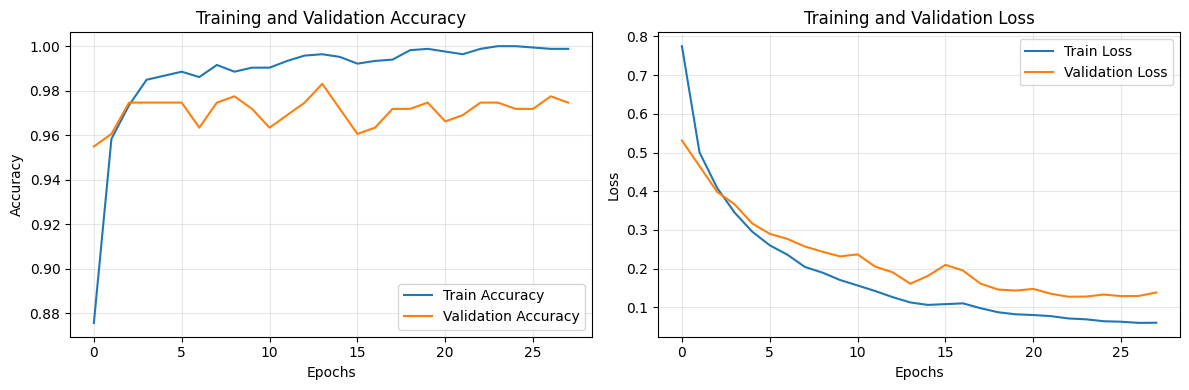

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.grid(True, alpha=0.3)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.grid(True, alpha=0.3)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.tight_layout()
plt.show()


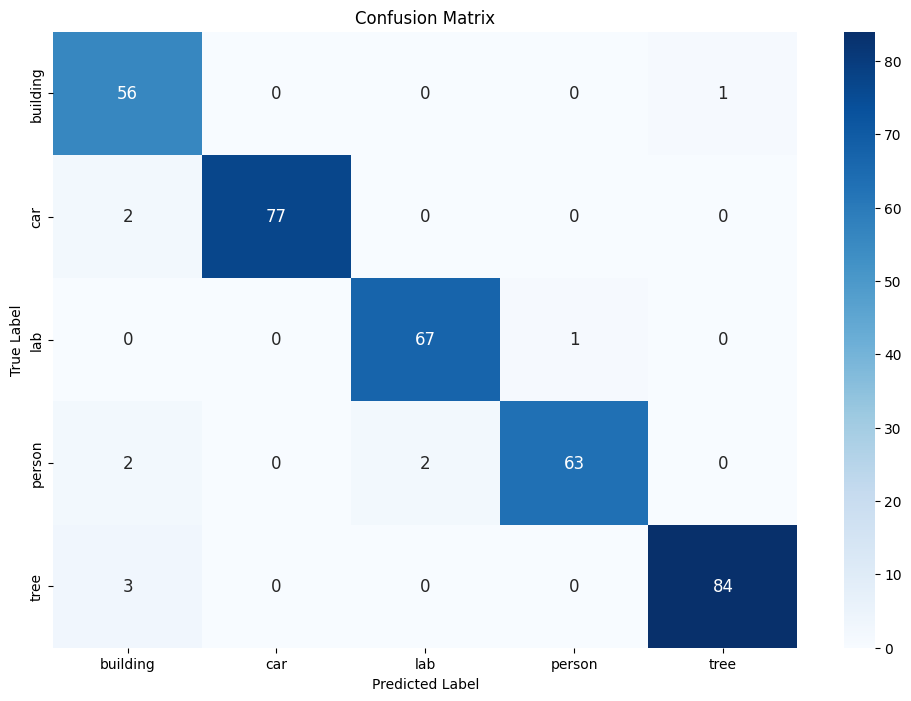

In [ ]:
#convision matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred, labels=labels)

plt.figure(figsize=(12,8))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names,
    annot_kws={"size": 12}
)


plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()
